In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Data

In [2]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


# Describe Data

In [3]:
print(olivetti.DESCR)


.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [4]:
olivetti.target


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

# Create Train, Dev, Test Set with StratifiedShuffleSplit

**Dataset is already scaled between 0 and 1.**

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [6]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


# Reduce data dimensionality using PCA:

In [7]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

#  K-Means without Data-Labels

In [8]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
                for k in k_range]
inertias = [model.inertia_ for model in kmeans_per_k]

# Silhouette_score Analysis

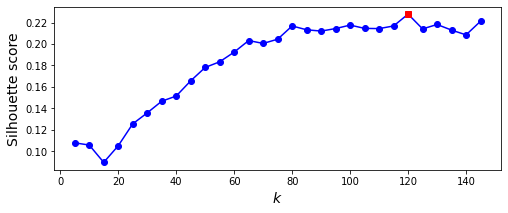

In [9]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

# Inertias Analysis

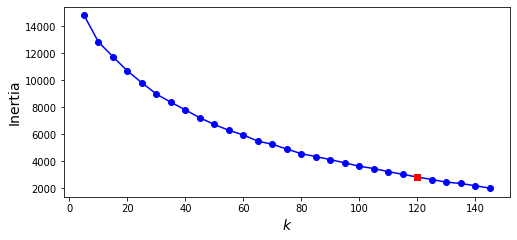

In [10]:
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(range(5, 150, 5), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")

plt.show()

In [11]:
best_k

120

# 120 looks the best. Let's try GridSearch.

In [12]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(n_clusters=range(5,150,5))
kmeans = KMeans(random_state=42)
grid = GridSearchCV(kmeans, param_grid, cv=3, verbose=2)
grid.fit(X_train_pca,y_train)

Fitting 3 folds for each of 29 candidates, totalling 87 fits
[CV] END .......................................n_clusters=5; total time=   0.3s
[CV] END .......................................n_clusters=5; total time=   0.3s
[CV] END .......................................n_clusters=5; total time=   0.3s
[CV] END ......................................n_clusters=10; total time=   0.4s
[CV] END ......................................n_clusters=10; total time=   0.7s
[CV] END ......................................n_clusters=10; total time=   0.7s
[CV] END ......................................n_clusters=15; total time=   0.6s
[CV] END ......................................n_clusters=15; total time=   0.3s
[CV] END ......................................n_clusters=15; total time=   0.3s
[CV] END ......................................n_clusters=20; total time=   0.7s
[CV] END ......................................n_clusters=20; total time=   0.7s
[CV] END ......................................n

GridSearchCV(cv=3, estimator=KMeans(random_state=42),
             param_grid={'n_clusters': range(5, 150, 5)}, verbose=2)

In [13]:
grid.best_params_


{'n_clusters': 130}

# GridSearch said 130.

In [14]:
grid_model = grid.best_estimator_
grid_model

KMeans(n_clusters=130, random_state=42)

In [15]:
best_model = kmeans_per_k[best_index]
best_model

KMeans(n_clusters=120, random_state=42)

# Let's compare the two models.

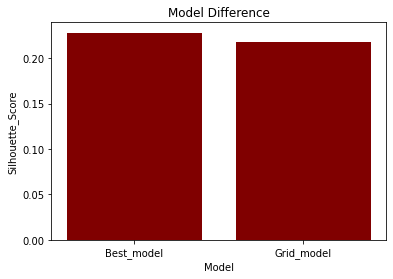

In [16]:
best_model_scores = (silhouette_score(X_train_pca, best_model.labels_))
grid_model_scores = (silhouette_score(X_train_pca, grid_model.labels_))

plt.bar(["Best_model", "Grid_model"], [best_model_scores, grid_model_scores], color ='maroon')
plt.xlabel("Model")
plt.ylabel("Silhouette_Score")
plt.title("Model Difference")
plt.show()


# Look at Clusters

Cluster 0


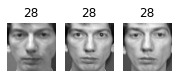

Cluster 1


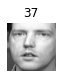

Cluster 2


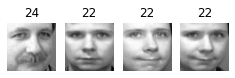

Cluster 3


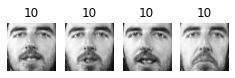

Cluster 4


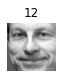

Cluster 5


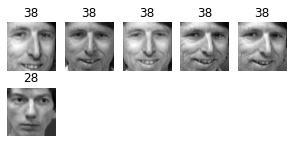

Cluster 6


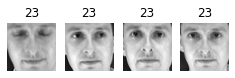

Cluster 7


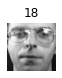

Cluster 8


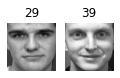

Cluster 9


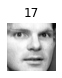

Cluster 10


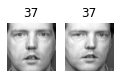

Cluster 11


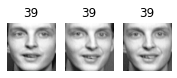

Cluster 12


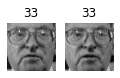

Cluster 13


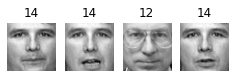

Cluster 14


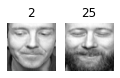

Cluster 15


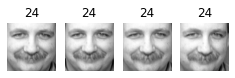

Cluster 16


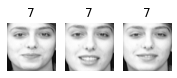

Cluster 17


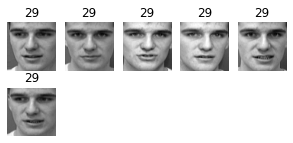

Cluster 18


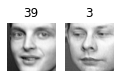

Cluster 19


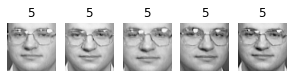

Cluster 20


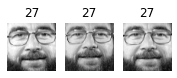

Cluster 21


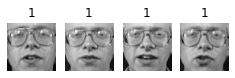

Cluster 22


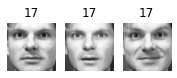

Cluster 23


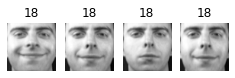

Cluster 24


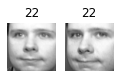

Cluster 25


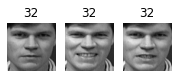

Cluster 26


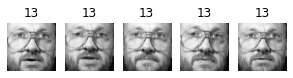

Cluster 27


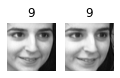

Cluster 28


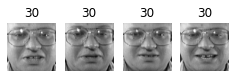

Cluster 29


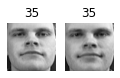

Cluster 30


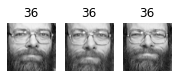

Cluster 31


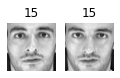

Cluster 32


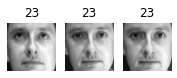

Cluster 33


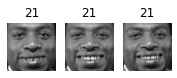

Cluster 34


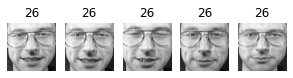

Cluster 35


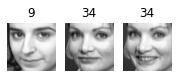

Cluster 36


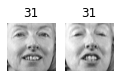

Cluster 37


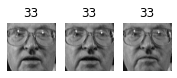

Cluster 38


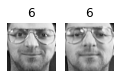

Cluster 39


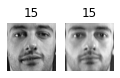

Cluster 40


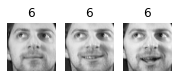

Cluster 41


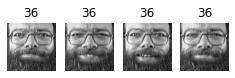

Cluster 42


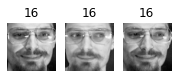

Cluster 43


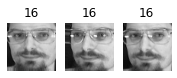

Cluster 44


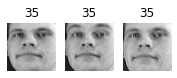

Cluster 45


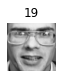

Cluster 46


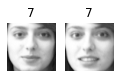

Cluster 47


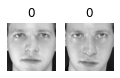

Cluster 48


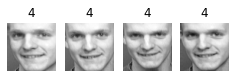

Cluster 49


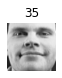

Cluster 50


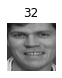

Cluster 51


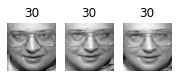

Cluster 52


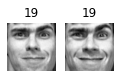

Cluster 53


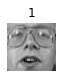

Cluster 54


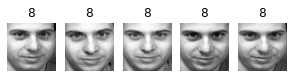

Cluster 55


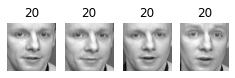

Cluster 56


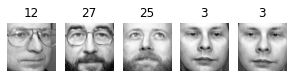

Cluster 57


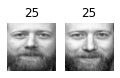

Cluster 58


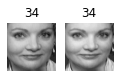

Cluster 59


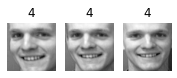

Cluster 60


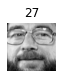

Cluster 61


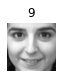

Cluster 62


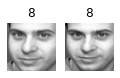

Cluster 63


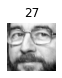

Cluster 64


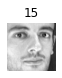

Cluster 65


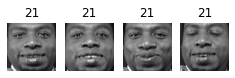

Cluster 66


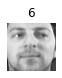

Cluster 67


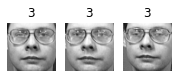

Cluster 68


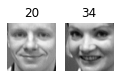

Cluster 69


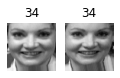

Cluster 70


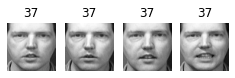

Cluster 71


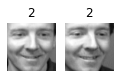

Cluster 72


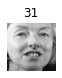

Cluster 73


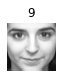

Cluster 74


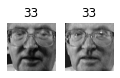

Cluster 75


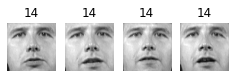

Cluster 76


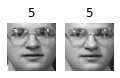

Cluster 77


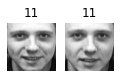

Cluster 78


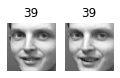

Cluster 79


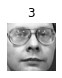

Cluster 80


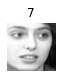

Cluster 81


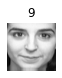

Cluster 82


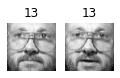

Cluster 83


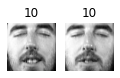

Cluster 84


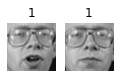

Cluster 85


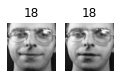

Cluster 86


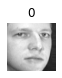

Cluster 87


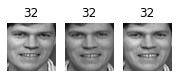

Cluster 88


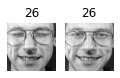

Cluster 89


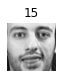

Cluster 90


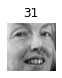

Cluster 91


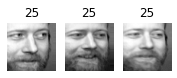

Cluster 92


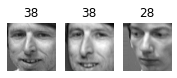

Cluster 93


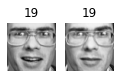

Cluster 94


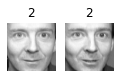

Cluster 95


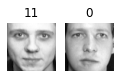

Cluster 96


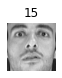

Cluster 97


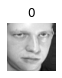

Cluster 98


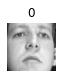

Cluster 99


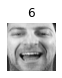

Cluster 100


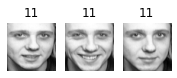

Cluster 101


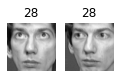

Cluster 102


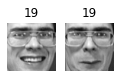

Cluster 103


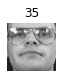

Cluster 104


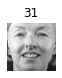

Cluster 105


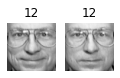

Cluster 106


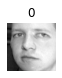

Cluster 107


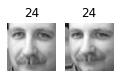

Cluster 108


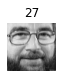

Cluster 109


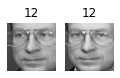

Cluster 110


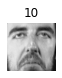

Cluster 111


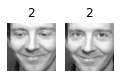

Cluster 112


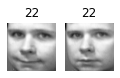

Cluster 113


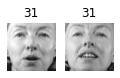

Cluster 114


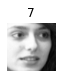

Cluster 115


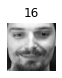

Cluster 116


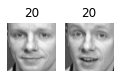

Cluster 117


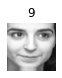

Cluster 118


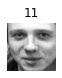

Cluster 119


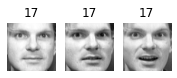

In [17]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

# GridSearch for Classifier

In [18]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
     'multi_class': ['multinomial','ovr'],
     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
     'max_iter' : [5000, 5500,6000, 6500]
    }
]
from sklearn.linear_model import LogisticRegression

logModel = LogisticRegression()
best_clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = best_clf.fit(X_train_pca, y_train)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search fail

In [19]:
best_clf.best_params_

{'max_iter': 5000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'liblinear'}

# Classifier with Real Labels

In [20]:
lreg_final = best_clf.best_estimator_

lreg_final.score(X_valid_pca, y_valid)

0.9875

# Classifier with K-Means Labels

In [21]:
from sklearn.pipeline import Pipeline
t = []
x = []

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("LReg", lreg_final)
    ])
    pipeline.fit(X_train_pca, y_train)
    t.append(n_clusters)
    x.append(pipeline.score(X_valid_pca, y_valid))

In [22]:
scores_clusters = pd.DataFrame(list(zip(t, x)),
               columns =['Clusters', 'Scores'])

scores_clusters.style.highlight_max(axis=0, props='background-color:green;', subset=['Scores'])

,Clusters,Scores
0,5,0.275000
1,10,0.662500
2,15,0.762500
3,20,0.812500
4,25,0.812500
5,30,0.862500
6,35,0.875000
7,40,0.875000
8,45,0.887500
9,50,0.925000


# Classification Report

In [24]:
from sklearn.metrics import classification_report

pipeline_valid_predict = pipeline.predict(X_valid_pca)

print(classification_report(y_valid,pipeline_valid_predict))


              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.33      0.50      0.40         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

# The clusters are not useful to directly train a classifier in this case (but they can still help when labelling new training instances).

# Thank You.